# Loading and preparing data

In [ ]:
# `numbat` kernel

# Copy-pasting this from last two scripts; modifying to just the relevant bits
library(tidyverse)
library(Seurat)
library(numbat)
library(future)
plan("multicore", workers = parallel::detectCores())

message_ <- function(m) {
    message(paste0(Sys.time(), ': ', m))
}

produce_numbat_seurat <- function(pat) {
    message_(paste(pat, 'via numbat'))
    projectdir <- file.path('/home/ubuntu/data/cxcr4-pdac')
    seu_file <- file.path(projectdir, 'seurat', pat, paste0(pat, '_cb.rds'))
    allele_pileup <- file.path(projectdir, 'numbat', pat, paste0(pat, '_allele_counts.tsv.gz')) # From pileup
    outdir <- file.path(projectdir, 'numbat', pat, 'numbat_downstream')  # From numbat.R
    gif_dir <- file.path(outdir, 'create_gif')

    nb = Numbat$new(out_dir = outdir)
    seu <- readRDS(seu_file)

    # Single-cell CNV calls
    cnv_calls<- nb$joint_post %>% select(cell, CHROM, seg, cnv_state, p_cnv, p_cnv_x, p_cnv_y)

    # Clone info
    clones<-dim(table(nb$clone_post$clone_opt))
    clone_info<-nb$clone_post
    

    seu@meta.data <- seu@meta.data %>% rownames_to_column('cell') %>%
                left_join(clone_info, by='cell')
    rownames(seu@meta.data) <- seu$cell
    return(seu)
}

filter_numbat_threshold <- function(seu,
                                    thresholds=seq(0,1,0.01), 
                                    min_prevalence = 10, 
                                    return_seurat_object = TRUE) {

    if (return_seurat_object) {
        stopifnot('To return seurat object, `thresholds` must be a scalar value' = length(thresholds) == 1)
    }

    samplename <- seu@meta.data$orig.ident %>% unique()
    stopifnot('Seurat object must only have a single `orig.ident`' = length(samplename) == 1)

    message_(paste('Creating filter for', samplename))
    pic_ct <- 0
    for (thresh in thresholds) {
        seu$selected <- seu$p_cnv_y > thresh
        # Cleanup
        prev_df <- seu@meta.data %>% 
                            group_by(seurat_clusters) %>% 
                            summarize(prevalence = 100 * sum(selected)/n()) %>%
                            filter(prevalence > min_prevalence) %>%
                            mutate(threshold=thresh)
        allowed_clusters <- prev_df$seurat_clusters
        seu$selected_filtered_numbat <- seu$selected & (seu$seurat_clusters %in% allowed_clusters)

        # Will only run if `thresholds` is a single value and we're not creating a gif
        if (return_seurat_object) {
            message_(paste0('Returning Seurat object for ', 
                             samplename, ' threshold ', thresh, 
                             ' and min prevalence ', min_prevalence,'%.'))
            return(seu)
        }
        pic_ct <- pic_ct + 1
    }
}


produce_infercnv_seurat <- function(pat) {
    message_(paste(pat, 'via infercnv'))
    projectdir <- file.path('/home/ubuntu/data/cxcr4-pdac')
    seu_file <- file.path(projectdir, 'infercnv', pat, paste0(pat, '_infercnv.rds'))
    
    outdir <- file.path(projectdir, 'infercnv', pat)
    gif_dir <- file.path(outdir, 'create_gif')

    seu <- readRDS(seu_file)
    seu@meta.data <- seu@meta.data[seu@meta.data$is_ref == 'not_ref', ]  # TODO: Put this part in 07_InferCNV.R !!
    return(seu)
}

# Only using the raw value for our purposes here!
filter_infercnv_threshold <- function(seu,
                                    thresholds=seq(0,1,0.01), 
                                    min_prevalence = 10, 
                                    return_seurat_object = TRUE) {

    if (return_seurat_object) {
        stopifnot('To return seurat object, `thresholds` must be a scalar value' = length(thresholds) == 1)
    }

    samplename <- seu@meta.data$orig.ident %>% unique()
    stopifnot('Seurat object must only have a single `orig.ident`: '= length(samplename) == 1)

    message_(paste('Computing thresholds for', samplename))

    message_(paste('Creating filter for', samplename))
    pic_ct <- 0
    for (thresh in thresholds) {
        # 
        seu$selected_infercnv_raw <- seu$proportion_cnv_avg > thresh
        prev_df_raw <- seu@meta.data %>% 
                            group_by(seurat_clusters) %>% 
                            summarize(prevalence = 100 * sum(selected_infercnv_raw)/n()) %>%
                            filter(prevalence > min_prevalence) %>%
                            mutate(threshold=thresh)
        allowed_clusters <- prev_df_raw$seurat_clusters
        seu$selected_filtered_infercnv <- seu$selected_infercnv_raw & (seu$seurat_clusters %in% allowed_clusters)


        # Will only run if `thresholds` is a single value and we're not creating a gif
        # TODO: DETERMINE HOW RETURNING WORKS
        if (return_seurat_object) {
            message_(paste0('Returning Seurat object for ', 
                             samplename, ' threshold ', thresh, 
                             ' and min prevalence ', min_prevalence,'%.'))
            return(seu)
        }
        pic_ct <- pic_ct + 1
    }
    
}


# Manual selection of putative malignant Seurat clusters
# based on UMAPs of PDAC_epi score
filter_infercnv_clusters <- function(seu,
                                    clusters = c(), 
                                    return_seurat_object = TRUE) {
    allowed_clusters <- clusters
    seu$selected_filtered_infercnv <- (seu$seurat_clusters %in% allowed_clusters)
    return(seu)
}

In [2]:
# The sample-wise thresholds for malignant cell prediction
# Most samples use their numbat thresholds
# The InferCNV samples use cluster-based annotation based on the PDAC_epi score

samples <- list()

samples[[1]] <- produce_numbat_seurat('GM18') %>% 
    filter_numbat_threshold(thresholds=0.43, min_prevalence=30)
samples[[2]] <- produce_numbat_seurat('GM19') %>% 
    filter_numbat_threshold(thresholds=0.10, min_prevalence=75)
samples[[3]] <- produce_numbat_seurat('GM20') %>% 
    filter_numbat_threshold(thresholds=0.12, min_prevalence=30)
samples[[4]] <- produce_numbat_seurat('GM21') %>% 
    filter_numbat_threshold(thresholds=0.30, min_prevalence=75)
samples[[5]] <- produce_infercnv_seurat('GM22') %>% 
    filter_infercnv_clusters(c(7))
samples[[6]] <- produce_numbat_seurat('GM23') %>% 
    filter_numbat_threshold(thresholds=0.15, min_prevalence=75)
samples[[7]] <- produce_infercnv_seurat('GM24') %>% 
    filter_infercnv_clusters(c(7))
samples[[8]] <- produce_numbat_seurat('GM26') %>% 
    filter_numbat_threshold(thresholds=0.15, min_prevalence=85)
samples[[9]] <- produce_numbat_seurat('GM27') %>% 
    filter_numbat_threshold(thresholds=0.05, min_prevalence=90)
samples[[10]] <- produce_numbat_seurat('GM28') %>% 
    filter_numbat_threshold(thresholds=0.15, min_prevalence=90)
samples[[11]] <- produce_infercnv_seurat('GM29') %>%
    filter_infercnv_clusters(c(11, 13))
samples[[12]] <- produce_numbat_seurat('GM30') %>% 
    filter_numbat_threshold(thresholds=0.20, min_prevalence=85)
samples[[13]] <- produce_numbat_seurat('GM31') %>% 
    filter_numbat_threshold(thresholds=0.05, min_prevalence=90)
samples[[14]] <- produce_numbat_seurat('GM32') %>% 
    filter_numbat_threshold(thresholds=0.10, min_prevalence=90)
samples[[15]] <- produce_numbat_seurat('GM33') %>% 
    filter_numbat_threshold(thresholds=0.45, min_prevalence=60)
samples[[16]] <- produce_infercnv_seurat('GM34') %>% 
    filter_infercnv_clusters(c())
samples[[17]] <- produce_infercnv_seurat('GM35') %>% 
    filter_infercnv_clusters(c(6))
samples[[18]] <- produce_infercnv_seurat('GM36') %>%
    filter_infercnv_clusters(c(6,10))
samples[[19]] <- produce_numbat_seurat('GM37') %>% 
    filter_numbat_threshold(thresholds=0.15, min_prevalence=80)
samples[[20]] <- produce_numbat_seurat('GM38') %>% 
    filter_numbat_threshold(thresholds=0.05, min_prevalence=50)
samples[[21]] <- produce_numbat_seurat('GM39') %>% 
    filter_numbat_threshold(thresholds=0.15, min_prevalence=90)
samples[[22]] <- produce_numbat_seurat('GM40') %>% 
    filter_numbat_threshold(thresholds=0.20, min_prevalence=90)

2023-10-13 21:29:51.411488: GM18 via numbat

2023-10-13 21:29:58.454796: Creating filter for GM18

2023-10-13 21:29:58.493316: Returning Seurat object for GM18 threshold 0.43 and min prevalence 30%.

2023-10-13 21:29:58.495963: GM19 via numbat

2023-10-13 21:30:05.34074: Creating filter for GM19

2023-10-13 21:30:05.375025: Returning Seurat object for GM19 threshold 0.1 and min prevalence 75%.

2023-10-13 21:30:05.377779: GM20 via numbat

2023-10-13 21:30:10.399343: Creating filter for GM20

2023-10-13 21:30:10.4333: Returning Seurat object for GM20 threshold 0.12 and min prevalence 30%.

2023-10-13 21:30:10.435953: GM21 via numbat

2023-10-13 21:30:12.900955: Creating filter for GM21

2023-10-13 21:30:12.933662: Returning Seurat object for GM21 threshold 0.3 and min prevalence 75%.

2023-10-13 21:30:12.944052: GM22 via infercnv

2023-10-13 21:30:13.446283: GM23 via numbat

2023-10-13 21:30:20.159971: Creating filter for GM23

2023-10-13 21:30:20.19508: Returning Seurat object for GM23

In [5]:
# Naive merge

message_('Starting merge block')
all_merged <- merge(samples[[1]], y = samples[-1], 
                    project = "cxcr4_merged",
                    merge.data = TRUE)

DefaultAssay(all_merged) <- "RNA"
all_merged <- FindVariableFeatures(all_merged)
all_merged <- ScaleData(all_merged, verbose = FALSE)
all_merged <- RunPCA(all_merged, npcs = 30, verbose = FALSE)
all_merged <- RunUMAP(all_merged, reduction = "pca", dims = 1:30)
all_merged <- FindNeighbors(all_merged, reduction = "pca", dims = 1:30)
all_merged <- FindClusters(all_merged, resolution = 0.5)


saveRDS(all_merged, '/home/ubuntu/data/cxcr4-pdac/combine_samples/merged.RDS')
rm(all_merged); gc()
message_('Ended merge block')

2023-10-13 20:17:24.683517: Starting merge block

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:19:11 UMAP embedding parameters a = 0.9922 b = 1.112

20:19:11 Read 91427 rows and found 30 numeric columns

20:19:11 Using Annoy for neighbor search, n_neighbors = 30

20:19:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:19:24 Writing NN index file to temp file /tmp/RtmpRtstH4/file688741455fb

20:19:24 Searching Annoy index using 1 thread, search_k = 3000

20:19:57 Annoy recall = 100%

20:19:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 91427
Number of edges: 3524278

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9541
Number of communities: 30
Elapsed time: 32 seconds


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3744571,200.0,5890867,314.7,5890867,314.7
Vcells,654250713,4991.6,1877676790,14325.6,2251512699,17177.7


2023-10-13 20:25:31.705619: Ended merge block



In [3]:
# And again with *full* integration

message_('Starting full integration block')

features <- SelectIntegrationFeatures(object.list = samples)
anchors <- FindIntegrationAnchors(object.list = samples, anchor.features = features)

message_('Starting actual integration')
combined <- IntegrateData(anchorset = anchors)
message_('Finished actual integration')

DefaultAssay(combined) <- "integrated"

# Run the standard workflow for visualization and clustering
combined <- ScaleData(combined, verbose = FALSE)
combined <- RunPCA(combined, npcs = 30, verbose = FALSE)
combined <- RunUMAP(combined, reduction = "pca", dims = 1:30)
combined <- FindNeighbors(combined, reduction = "pca", dims = 1:30)
combined <- FindClusters(combined, resolution = 0.5)

# Don't want to accidentally overwrite this lol
saveRDS(combined, '/home/ubuntu/data/cxcr4-pdac/combine_samples/combined.RDS')
rm(combined); gc()

message_('Ending full integration block')

# Looks like this took just about 3-4h. Unclear if it was r5.4xlarge 
# but was more likely r5.8xlarge

2023-10-13 21:31:17.193579: Starting full integration block



Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7347 anchors

Filtering anchors

	Retained 4082 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8969 anchors

Filtering anchors

	Retained 5205 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8714 anchors

Filtering anchors

	Retained 4196 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5242 anchors

Filtering anchors

	Retained 2812 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5611 anchors

Filtering anchors

	Retained 2473 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5672 anchors

Fi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 91427
Number of edges: 4122833

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9267
Number of communities: 20
Elapsed time: 39 seconds


1 singletons identified. 19 final clusters.



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3879241,207.2,5890802,314.7,5890802,314.7
Vcells,848020493,6469.9,4205252285,32083.6,6570697271,50130.5


2023-10-14 00:53:18.770124: Ending full integration block



In [15]:
# This is Mori's integration method, 

integ_subset <- function(subset) {
    subset.list <- SplitObject(subset, split.by = "orig.ident")

    # We've already computed this and it doesn't get lost during merge
    # subset.list <- lapply(X = subset.list, FUN = function(x) {
    #     x <- NormalizeData(x)
    #     x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    # })

    message('SELECTING INTEGRATION FEATURES')
    features <- SelectIntegrationFeatures(object.list = subset.list)
    message('FINDING INTEGRATION ANCHORS')
    anchors <- FindIntegrationAnchors(object.list = subset.list, anchor.features = features)
    message('INTEGRATING')
    combined <- IntegrateData(anchorset = anchors)
    # DefaultAssay(combined) <- "integrated"

    # combined <- ScaleData(combined, verbose = FALSE)
    # combined <- RunPCA(combined, npcs = 30, verbose = FALSE)
    # combined <- RunUMAP(combined, reduction = "pca", dims = 1:30)
    # combined <- FindNeighbors(combined, reduction = "pca", dims = 1:30)
    # combined <- FindClusters(combined, resolution = 0.5)
    message('DONE')
    return(combined)
}

all_merged <- readRDS('/home/ubuntu/data/cxcr4-pdac/combine_samples/merged.RDS')
malig <- subset(all_merged, selected_filtered_numbat == TRUE)
non_malig <- subset(all_merged, selected_filtered_numbat == FALSE | is.na(selected_filtered_numbat))
rm(all_merged); gc()


malig <- integ_subset(malig)
saveRDS(malig, '/home/ubuntu/data/cxcr4-pdac/combine_samples/integ_malig.RDS')
# rm(malig); gc()


non_malig <- integ_subset(non_malig)
saveRDS(non_malig, '/home/ubuntu/data/cxcr4-pdac/combine_samples/integ_nonmalig.RDS')
# rm(non_malig); gc()


combined_separate_integ <- merge(malig, y = non_malig,
                    project = "cxcr4_merged",
                    merge.data = TRUE)
rm(malig); rm(non_malig); gc()

DefaultAssay(combined_separate_integ) <- "RNA"
combined_separate_integ <- FindVariableFeatures(combined_separate_integ)
combined_separate_integ <- ScaleData(combined_separate_integ, verbose = FALSE)
combined_separate_integ <- RunPCA(combined_separate_integ, npcs = 30, verbose = FALSE)
combined_separate_integ <- RunUMAP(combined_separate_integ, reduction = "pca", dims = 1:30)
combined_separate_integ <- FindNeighbors(combined_separate_integ, reduction = "pca", dims = 1:30)
combined_separate_integ <- FindClusters(combined_separate_integ, resolution = 0.5)
saveRDS(combined_separate_integ, '/home/ubuntu/data/cxcr4-pdac/combine_samples/combined_separate_integ.RDS')

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3727479,199.1,5891002,314.7,5891002,314.7
Vcells,1872725986,14287.8,3886065478,29648.4,3823914928,29174.2


SELECTING INTEGRATION FEATURES

FINDING INTEGRATION ANCHORS

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1170 anchors

Filtering anchors

	Retained 287 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1162 anchors

Filtering anchors

	Retained 559 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4688 anchors

Filtering anchors

	Retained 2189 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1051 anchors

Filtering anchors

	Retained 847 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1592 anchors

Filtering anchors

	Retained 1339 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1568 anchors

Filtering anchors

	Retained 1325 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3760022,200.9,5891007,314.7,5891007,314.7
Vcells,1930465789,14728.3,6446859850,49185.7,8031911256,61278.7


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:14:56 UMAP embedding parameters a = 0.9922 b = 1.112

21:14:56 Read 91427 rows and found 30 numeric columns

21:14:56 Using Annoy for neighbor search, n_neighbors = 30

21:14:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:15:10 Writing NN index file to temp file /tmp/RtmpCoBA8H/file68169616ae3

21:15:10 Searching Annoy index using 1 thread, search_k = 3000

21:15:45 Annoy recall = 100%

21:15:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 91427
Number of edges: 3525882

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9542
Number of communities: 29
Elapsed time: 29 seconds


# Visualization

In [2]:
# `numbat` env kernel
library(tidyverse)
library(patchwork)
library(Seurat)
library(viridis)

process_for_plotting <- function(seu) {
        probation_samples <- c('GM22', 'GM24', 'GM29', 'GM34', 'GM35', 'GM36')  # Potentially noisy since we couldn't predict on numbat alone

        seu@meta.data$selected_filtered_infercnv[is.na(seu@meta.data$selected_filtered_infercnv)] <- FALSE
        seu@meta.data$selected_filtered_numbat[is.na(seu@meta.data$selected_filtered_numbat)] <- FALSE
        seu$MALIGNANT_PRED <- (seu@meta.data$selected_filtered_infercnv | seu@meta.data$selected_filtered_numbat)
        seu$MALIGNANT_PRED[seu@meta.data$selected_filtered_infercnv] <- 'NON MALIGNANT' 
        seu$MALIGNANT_PRED[seu@meta.data$selected_filtered_numbat] <- 'MALIGNANT_NUMBAT'
        seu$MALIGNANT_PRED[!as.logical(seu$MALIGNANT_PRED)] <- 'NON MALIGNANT'
        seu$potentially_noisy_samplemple <- seu$orig.ident %in% probation_samples

        # Citations:
        # Biermann J, Melms JC, Amin AD, Wang Y, Caprio LA, Karz A, Tagore S, Barrera I, Ibarra-Arellano MA, Andreatta M, Fullerton BT, Gretarsson KH, Sahu V, Mangipudy VS, Nguyen TTT, Nair A, Rogava M, Ho P, Koch PD, Banu M, Humala N, Mahajan A, Walsh ZH, Shah SB, Vaccaro DH, Caldwell B, Mu M, Wünnemann F, Chazotte M, Berhe S, Luoma AM, Driver J, Ingham M, Khan SA, Rapisuwon S, Slingluff CL Jr, Eigentler T, Röcken M, Carvajal R, Atkins MB, Davies MA, Agustinus A, Bakhoum SF, Azizi E, Siegelin M, Lu C, Carmona SJ, Hibshoosh H, Ribas A, Canoll P, Bruce JN, Bi WL, Agrawal P, Schapiro D, Hernando E, Macosko EZ, Chen F, Schwartz GK, Izar B. Dissecting the treatment-naive ecosystem of human melanoma brain metastasis. Cell. 2022 Jul 7;185(14):2591-2608.e30. doi: 10.1016/j.cell.2022.06.007. PMID: 35803246; PMCID: PMC9677434.
        # Melms JC, Biermann J, Huang H, Wang Y, Nair A, Tagore S, Katsyv I, Rendeiro AF, Amin AD, Schapiro D, Frangieh CJ, Luoma AM, Filliol A, Fang Y, Ravichandran H, Clausi MG, Alba GA, Rogava M, Chen SW, Ho P, Montoro DT, Kornberg AE, Han AS, Bakhoum MF, Anandasabapathy N, Suárez-Fariñas M, Bakhoum SF, Bram Y, Borczuk A, Guo XV, Lefkowitch JH, Marboe C, Lagana SM, Del Portillo A, Tsai EJ, Zorn E, Markowitz GS, Schwabe RF, Schwartz RE, Elemento O, Saqi A, Hibshoosh H, Que J, Izar B. A molecular single-cell lung atlas of lethal COVID-19. Nature. 2021 Jul;595(7865):114-119. doi: 10.1038/s41586-021-03569-1. Epub 2021 Apr 29. Erratum in: Nature. 2021 Oct;598(7882):E2. PMID: 33915568; PMCID: PMC8814825.
        # Chuan Xu, Martin Prete, Simone Webb, Laura Jardine, Benjamin Stewart, Regina Hoo, Peng He, Sarah A. Teichmann. Automatic cell type harmonization and integration across Human Cell Atlas datasets. bioRxiv 2023.05.01.538994 (2023).
        # Franzén O, Gan LM, Björkegren JLM. PanglaoDB: a web server for exploration of mouse and human single-cell RNA sequencing data. Database (Oxford). 2019 Jan 1;2019:baz046. doi: 10.1093/database/baz046. PMID: 30951143; PMCID: PMC6450036.

        filter_unused_genes <- function(gene_list, listname) {
                out <- gene_list[gene_list %in% rownames(seu)]
                unused <- gene_list[!(gene_list %in% rownames(seu))]

                if (length(unused) > 0) message(paste('List', listname, ': filtering out genes', toString(unused)))
                return(list(out))
        }

        # https://github.com/satijalab/seurat/issues/5841 Assay must be RNA
        is_integrated <- FALSE
        if (DefaultAssay(seu) == 'integrated') {
                is_integrated <- TRUE
                DefaultAssay(seu) <- 'RNA'
        }

        genes_t_cells <- c('BCL11B', 'FYN',   'IKZF1',   'CCL5',   'LYST',  'CD247',   'CBLB', 'IQGAP2',  'ETS1', 'SKAP1',  'ELMO1',  'ITGA4', 'DTDH1','AOAH',   'PTPRC',  'CD44',  'PYHIN1',  'CD8A',  'CD96', 'IFI6',  'NFAT5',  'THEMIS', 'PRKCH',  'ITK',  'PDE3B',  'BACH2','NCK2',  'CELF2',  'ITGA1', 'RBPJ',  'TNIK',   'LEF1',   'RIPOR2', 'AKT3', 'RORA', 'FOXP1',  'NCAM1',   'KLRC1',   'KLRC2','KLRD1',  'LYN',  'NCR1',   'KLRK1',  'RPLP1', 'RPL41','RPL13',  'ACTB',  'B2M', 'STAT4',   'RUNX2',   'ITGA4','ITGA1','CD69', 'ITGAE',   'CD44', 'CD58','IL2RA',  'TBC1D4',  'CTLA4','ICOS', 'CD4') %>% filter_unused_genes('T cell')
        genes_myeloid <- c('CLEC9A','XCR1',  'CLNK', 'SLC38A1','RTN1','SIRPA','IDO1','LAMP3','CD200','MS4A2','KIT','MRC1','MERTK','FCGR1A','CD38','CD163L1','SELENOP','F13A1','DAB2','SIGLEC1','FTL','FTH1','NAV3','C3','P2RY12','VCAN','FCN1','LYZ') %>% filter_unused_genes('Myeloid')
        genes_endothelial <- c('VEGFC', 'DLL4' ,'EFNB2' ,'RGCC', 'KIAA1217', 'ARHGAP18', 'MMRN1', 'FLT4', 'SEMA3D','RELN', 'IL1R1', 'NR2F2', 'CDH11', 'MKI67' ) %>% filter_unused_genes('Endothelial')
        genes_fibroblasts <- c('RGS5', 'CSPG4', 'ABCC9', 'PDGFRA', 'LUM', 'DCN', 'CTHRC1', 'COL1A1' ,'COL3A1', 'COL6A1' ,'LAMA2' ) %>% filter_unused_genes('Fibroblasts')
        genes_bcells <- c('BANK1','BLK','MKI67','TOP2A','SDC1','CD38','PRDM1', 'CD19', 'CD20' ) %>% filter_unused_genes('B cells')  # Added CD19 and CD20
        genes_neuronal <- c('GFAP', 'AQP4', 'SLC1A2', 'GJA1', 'RELN', 'NRGN', 'STX1A', 'NEFH', 'SYP', 'SNRPN', 'SATB2', 'SLC17A7', 'GAD1', 'GAD2', 'SLC32A1', 'SLC6A1', 'MAG', 'MOG', 'MBP', 'MOBP', 'VCAN', 'CSPG4', 'SOX10', 'OLIG1' ) %>% filter_unused_genes('Neuronal')

        # From Mori
        genes_pdac_epi <- c('AGR2','CTSE','GABRP','SFN','KLK10','PSCA','TSTD1','PIGR', 'LGALS4','FERMT1','RNF128','ECT2','CCL20','SPTSSB','VSIG2', 'AQP3','CDH3','KRT7','KRT16','KRT15','MUC1','MUC5AC','EPCAM', 'CEACAM1','ITGB4','ITGA2','TSPAN1','TSPAN8') %>% filter_unused_genes('PDAC_epi')


        seu <- AddModuleScore(seu, features=genes_pdac_epi, name='PDAC.epi.score', assay='RNA')
        seu <- AddModuleScore(seu, features=genes_t_cells, name='T.cell.score', assay='RNA')
        seu <- AddModuleScore(seu, features=genes_myeloid, name='Myeloid.score', assay='RNA')
        seu <- AddModuleScore(seu, features=genes_endothelial, name='Endothelial.score', assay='RNA')
        seu <- AddModuleScore(seu, features=genes_fibroblasts, name='Fibroblast.score', assay='RNA')
        seu <- AddModuleScore(seu, features=genes_bcells, name='B.cell.score', assay='RNA')
        seu <- AddModuleScore(seu, features=genes_neuronal, name='Neuronal.score', assay='RNA')

        if (is_integrated) {
                DefaultAssay(seu) <- 'integrated'
        }

        metadata <- data.frame(
        orig.ident = paste0('GM', seq(16, 40)),
        pt.id = c('001-01', '001-03', '001-04', '001-05', '001-06', '001-08', '001-12', '001-18', '001-19', '002-01', '002-02',
                  '001-01', '001-03', '001-04', '001-05', '001-06', '001-08', '001-12', '001-18', '001-19', '002-01', '002-02',
                  '001-03', '001-04', '001-06'),
        treatment.stage = c(rep('PRE', 11), rep('ON_TRT', 11), rep('ON_PROG', 3)),
        age = c(62, 58, 58, 58, 46, 68, 58, 69, 63, 68, 47,
                62, 58, 58, 58, 46, 68, 58, 69, 63, 68, 47,
                58, 58, 46),
        race = c('White', 'White', 'White', 'Black/AA', 'Black/AA', 'White', 'White', 'Black/AA', 'White', 'White', 'White',
                 'White', 'White', 'White', 'Black/AA', 'Black/AA', 'White', 'White', 'Black/AA', 'White', 'White', 'White',
                 'White', 'White', 'Black/AA'),
        sex = c('M', 'F', 'M', 'M', 'M', 'F', rep('M', 5),
                'M', 'F', 'M', 'M', 'M', 'F', rep('M', 5),
                'F', 'M', 'M'),
        ethnicity = c('Not Hispanic', 'Not Hispanic', 'Dominican', 'Not Hispanic', 'Dominican', rep('Not Hispanic', 6),
                        'Not Hispanic', 'Not Hispanic', 'Dominican', 'Not Hispanic', 'Dominican', rep('Not Hispanic', 6),
                        'Not Hispanic', 'Dominican', 'Dominican'),
        response = c('PR', 'SD', 'PR', 'PD', rep('PR', 5), 'SD', 'PD',
                        'PR', 'SD', 'PR', 'PD', rep('PR', 5), 'SD', 'PD',
                        'SD', 'PR', 'PR')
        )


        barcodes <- rownames(seu@meta.data)
        seu@meta.data <- merge(x=seu@meta.data, y=metadata, 
                               by=c("orig.ident","orig.ident"), all.x=TRUE, all.y=FALSE)
        rownames(seu@meta.data) <- barcodes  # Prevent ID loss during left join

        return(seu)
}


make_plots <- function(seu) {
        p1 <- DimPlot(seu, group.by = 'seurat_clusters',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none')
        p2 <- DimPlot(seu, group.by = 'orig.ident',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none')
        p3 <- DimPlot(seu, group.by = 'celltype_bped_main',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none')
        p4 <- DimPlot(seu, group.by = 'potentially_noisy_sample',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none') +
                scale_color_manual(values=c("TRUE" = "red", "FALSE" = "blue"))
        p5 <- DimPlot(seu, group.by = 'MALIGNANT_PRED',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none') +
                scale_color_manual(values=c("MALIGNANT_NUMBAT" = "red", 
                                        "MALIGNANT_INFERCNV" = "green", 
                                        "NON MALIGNANT"='blue'))

        return(list('p1'=p1, 'p2'=p2, 'p3'=p3, 'p4'=p4, 'p5'=p5))
}

make_plots_markers <- function(seu) {
        p1 <- FeaturePlot(seu,
                         reduction = "umap", features='PDAC.epi.score1') + 
                         theme(legend.position='none') + scale_color_viridis()
        p2 <- FeaturePlot(seu, 
                         reduction = "umap", features='T.cell.score1') + 
                         theme(legend.position='none') + scale_color_viridis()
        p3 <- FeaturePlot(seu, 
                         reduction = "umap", features='Myeloid.score1') + 
                         theme(legend.position='none') + scale_color_viridis()
        p4 <- FeaturePlot(seu, 
                         reduction = "umap", features='Endothelial.score1') + 
                         theme(legend.position='none') + scale_color_viridis()
        p5 <- FeaturePlot(seu,
                         reduction = "umap", features='Fibroblast.score1') + 
                         theme(legend.position='none') + scale_color_viridis()
        p6 <- FeaturePlot(seu,
                         reduction = "umap", features='B.cell.score1') + 
                         theme(legend.position='none') + scale_color_viridis()
        p7 <- FeaturePlot(seu,
                         reduction = "umap", features='Neuronal.score1') + 
                         theme(legend.position='none') + scale_color_viridis()

        return(list('p1'=p1, 'p2'=p2, 'p3'=p3, 'p4'=p4, 'p5'=p5, 'p6'=p6, 'p7'=p7))
}

make_plots_demog <- function(seu) {
        p1 <- DimPlot(seu, group.by = 'pt.id',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none')
        p2 <- DimPlot(seu, group.by = 'treatment.stage',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none') +
                scale_color_manual(values=c("PRE" = "red", 
                                        "ON_TRT" = "green", 
                                        "ON_PROG"='blue'))
        p3 <- FeaturePlot(seu, features='age',
                reduction = "umap", label = T, raster = T) + scale_color_viridis()
        p4 <- DimPlot(seu, group.by = 'race',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none')
        p5 <- DimPlot(seu, group.by = 'ethnicity',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none')
        p6 <- DimPlot(seu, group.by = 'sex',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none') +
                scale_color_manual(values=c("M" = "blue", 
                                            "F" = "red"))
        p7 <- DimPlot(seu, group.by = 'response',
                reduction = "umap", label = T, raster = T, shuffle = T) + 
                theme(legend.position='none') +
                scale_color_manual(values=c("CR" = "green", 
                                           "PR" = "blue", 
                                        "SD"='yellow',
                                        "PD"='red'))

        return(list('p1'=p1, 'p2'=p2, 'p3'=p3, 'p4'=p4, 'p5'=p5, 'p6'=p6, 'p7'=p7))
}




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Att

In [3]:
all_merged <- '/home/ubuntu/data/cxcr4-pdac/combine_samples/merged.RDS'
combined <- '/home/ubuntu/data/cxcr4-pdac/combine_samples/combined_separate_integ.RDS'
nonmalig <- '/home/ubuntu/data/cxcr4-pdac/combine_samples/integ_nonmalig.RDS'
malig <- '/home/ubuntu/data/cxcr4-pdac/combine_samples/integ_malig.RDS'




prep_umap <- function(seu) {
    DefaultAssay(seu) <- 'RNA'
    seu <- NormalizeData(seu)
    seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures = 2000)

    DefaultAssay(seu) <- "integrated"
    seu <- ScaleData(seu, verbose = FALSE)
    seu <- RunPCA(seu, npcs = 30, verbose = FALSE)
    seu <- RunUMAP(seu, reduction = "pca", dims = 1:30)
    seu <- FindNeighbors(seu, reduction = "pca", dims = 1:30)
    seu <- FindClusters(seu, resolution = 0.5)
    return(seu)
}

message('All merged')
# all_merged <- readRDS(all_merged) %>% process_for_plotting()
# message('Combined')
# combined <- readRDS(combined) %>% process_for_plotting()
malig <- readRDS(malig) %>% prep_umap() %>% process_for_plotting()
nonmalig <- readRDS(nonmalig) %>% prep_umap() %>% process_for_plotting()


All merged



Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:59:56 UMAP embedding parameters a = 0.9922 b = 1.112

15:59:56 Read 19693 rows and found 30 numeric columns

15:59:56 Using Annoy for neighbor search, n_neighbors = 30

15:59:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:59:59 Writing NN index file to temp file /tmp/RtmpoJdStw/file5f76db48852

15:59:59 Searching Annoy index using 1 thread, search_k = 3000

16:00:06 Annoy recall = 100%

16:00:07 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19693
Number of edges: 903912

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8451
Number of communities: 14
Elapsed time: 3 seconds


List T cell : filtering out genes DTDH1

List B cells : filtering out genes CD20

16:02:00 UMAP embedding parameters a = 0.9922 b = 1.112

16:02:00 Read 71734 rows and found 30 numeric columns

16:02:00 Using Annoy for neighbor search, n_neighbors = 30

16:02:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:02:16 Writing NN index file to temp file /tmp/RtmpoJdStw/file5f74725708b

16:02:16 Searching Annoy index using 1 thread, search_k = 3000

16:02:52 Annoy recall = 100%

16:02:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:02:55 Initializing from normalized Laplacian + noise (using irlba)

16:03:07 Commencing optimization for 200 epochs, with 3553196 positive edges

16:03:51 Optimization finished

Computing nearest 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 71734
Number of edges: 3412406

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9203
Number of communities: 21
Elapsed time: 31 seconds


3 singletons identified. 18 final clusters.

List T cell : filtering out genes DTDH1

List B cells : filtering out genes CD20



In [73]:
malig$HELLO <- 'a'
nonmalig$HELLO <- 'b'
combined <- merge(malig, y=nonmalig, merge.data=TRUE)

integ_subset2 <- function(subset) {
    subset.list <- SplitObject(subset, split.by = "HELLO")

    # We've already computed this and it doesn't get lost during merge
    subset.list <- lapply(X = subset.list, FUN = function(x) {
        DefaultAssay(x) <- 'RNA'
        x <- NormalizeData(x)
        x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    })

    message('SELECTING INTEGRATION FEATURES')
    features <- SelectIntegrationFeatures(object.list = subset.list)
    message('FINDING INTEGRATION ANCHORS')
    anchors <- FindIntegrationAnchors(object.list = subset.list, anchor.features = features)
    message('INTEGRATING')
    combined <- IntegrateData(anchorset = anchors)
    DefaultAssay(combined) <- "integrated"

    combined <- ScaleData(combined, verbose = FALSE)
    combined <- RunPCA(combined, npcs = 30, verbose = FALSE)
    combined <- RunUMAP(combined, reduction = "pca", dims = 1:30)
    combined <- FindNeighbors(combined, reduction = "pca", dims = 1:30)
    combined <- FindClusters(combined, resolution = 0.5)
    message('DONE')
    return(combined)
}
combined <- integ_subset2(combined)

In [ ]:
mrg <- make_plots(nonmalig)
cmb <- make_plots(malig)

options(rept.plot.width=20, repr.plot.height=15)
(
        (mrg[['p1']] | cmb[['p1']]) / 
        (mrg[['p2']] | cmb[['p2']]) / 
        (mrg[['p3']] | cmb[['p3']]) /
        (mrg[['p4']] | cmb[['p4']]) /
        (mrg[['p5']] | cmb[['p5']])
)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is

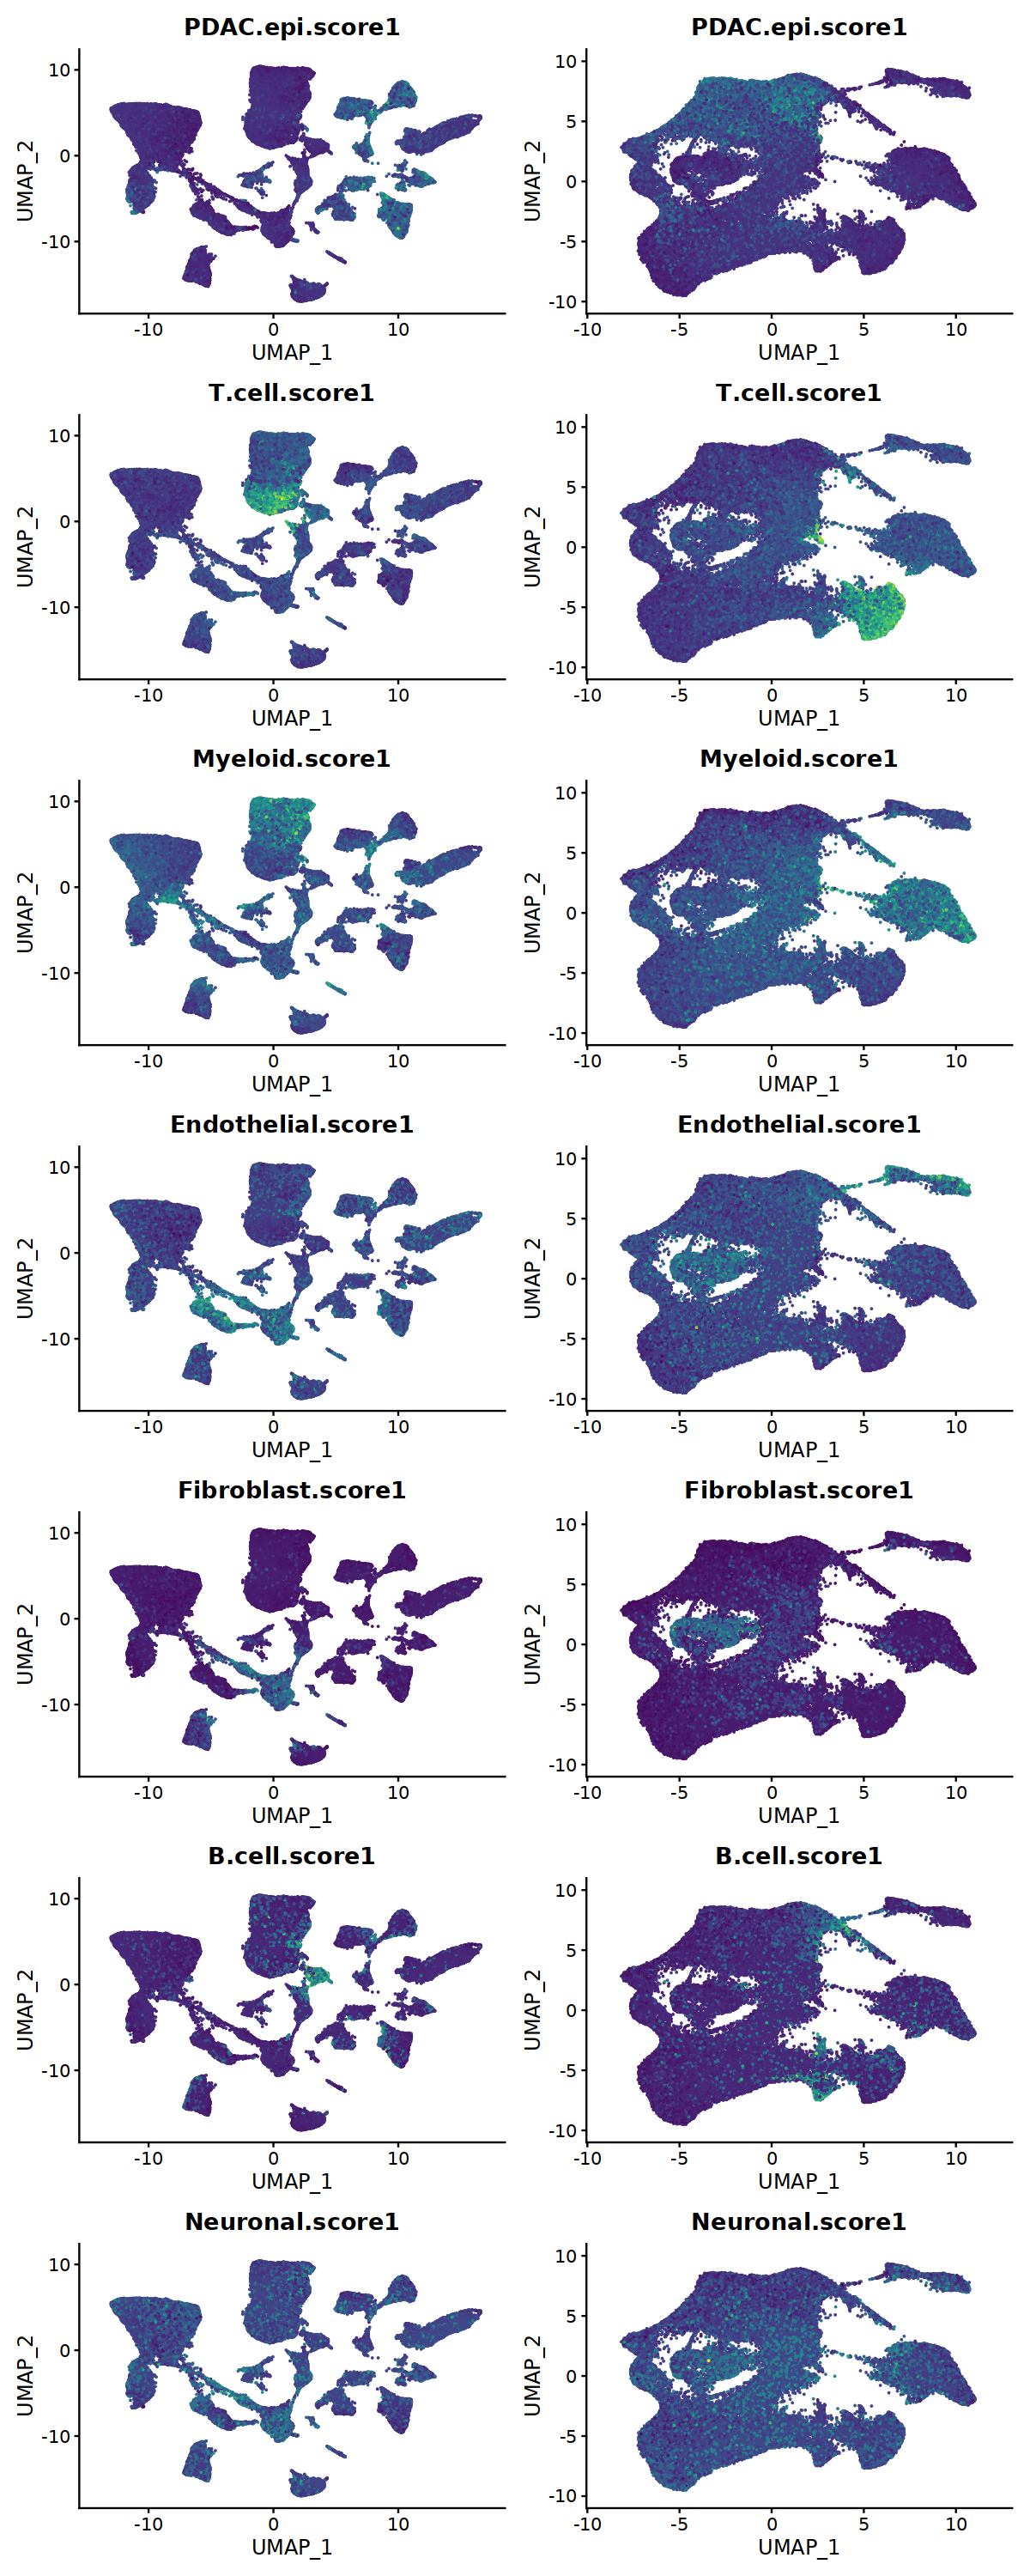

In [119]:
mrg <- make_plots_markers(all_merged)
cmb <- make_plots_markers(combined)

options(rept.plot.width=20, repr.plot.height=25)
(
        (mrg[['p1']] | cmb[['p1']]) / 
        (mrg[['p2']] | cmb[['p2']]) / 
        (mrg[['p3']] | cmb[['p3']]) /
        (mrg[['p4']] | cmb[['p4']]) /
        (mrg[['p5']] | cmb[['p5']]) /
        (mrg[['p6']] | cmb[['p6']]) /
        (mrg[['p7']] | cmb[['p7']])
)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


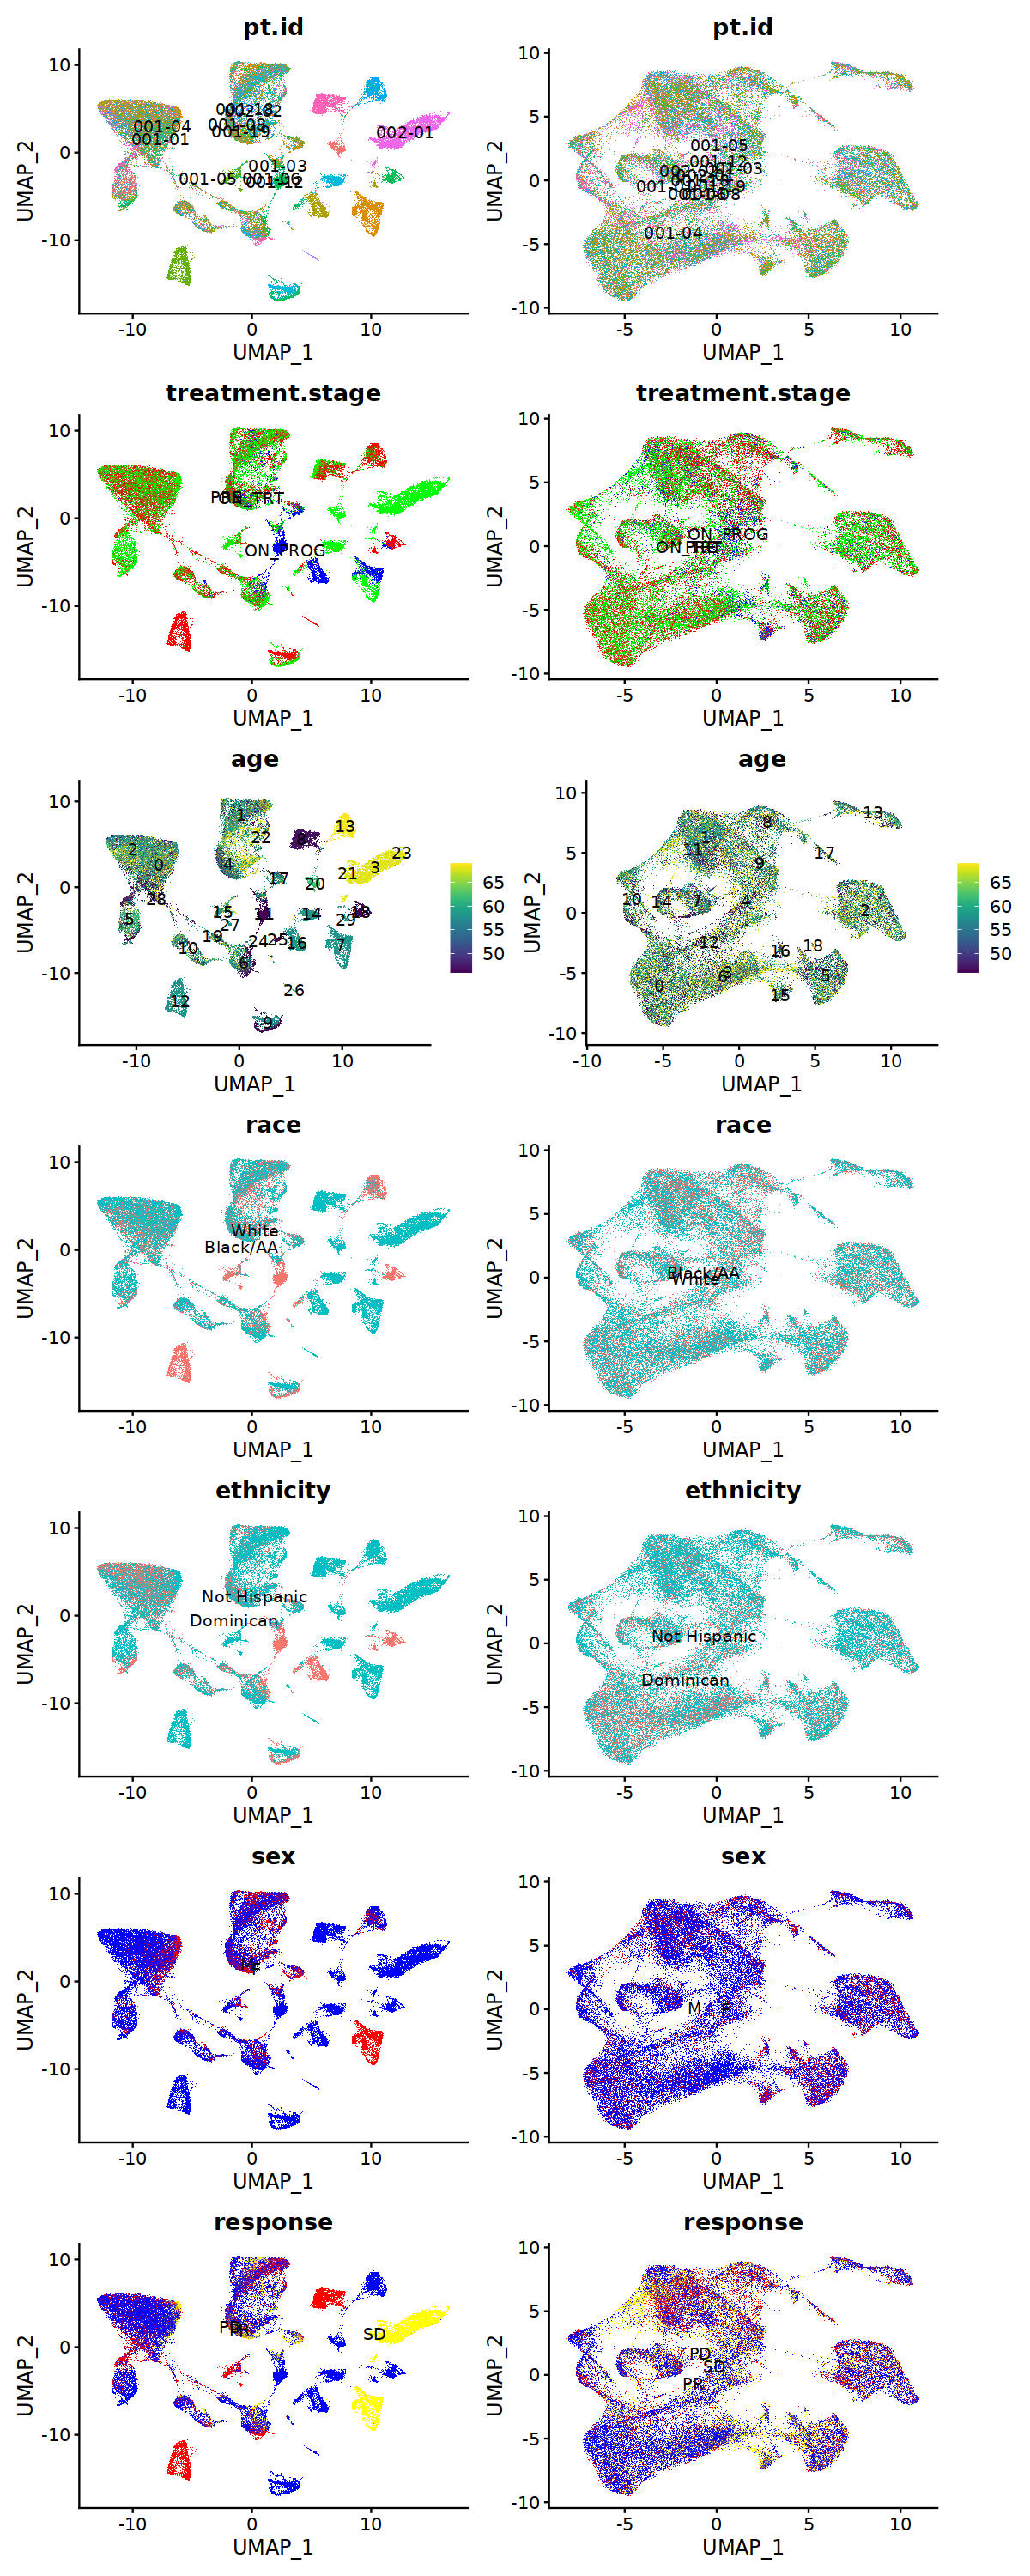

In [120]:
mrg <- make_plots_demog(all_merged)
cmb <- make_plots_demog(combined)

options(rept.plot.width=20, repr.plot.height=25)
(
        (mrg[['p1']] | cmb[['p1']]) / 
        (mrg[['p2']] | cmb[['p2']]) / 
        (mrg[['p3']] | cmb[['p3']]) /
        (mrg[['p4']] | cmb[['p4']]) /
        (mrg[['p5']] | cmb[['p5']]) /
        (mrg[['p6']] | cmb[['p6']]) /
        (mrg[['p7']] | cmb[['p7']])
)

# Showing pre vs post integration demographic results